In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (14, 8)
import wrangle

# Acquisition, prep, and split

In [2]:
# Pulling in all data, cleaning and displaying info
aquifer, temps, precip, pop, usage = wrangle.get_dataframes()
aquifer, weather, pop, usage = wrangle.clean_all_dataframes(aquifer, temps, precip, pop, usage)
aquifer.info(), weather.info(), pop.info(), usage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31919 entries, 1932-11-12 to 2022-06-12
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   water_level_elevation  31919 non-null  float64
dtypes: float64(1)
memory usage: 498.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1529 entries, 1895-01-01 to 2022-05-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_monthly_temp      1529 non-null   float64
 1   total_monthly_precip  1529 non-null   float64
dtypes: float64(2)
memory usage: 35.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 1850-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   population  38 non-null     int64
dtypes: int64(1)
memory usage: 608.0 bytes
<class 'pandas.core.frame.

(None, None, None, None)

In [3]:
# Setting train size to be 60% of the total dataset
train_size = int(round(aquifer.shape[0] * 0.6))

# set validate size to be 25% of the total dataset
validate_size = int(round(aquifer.shape[0] * 0.25))

# Setting test size to be 15% of the total dataset. 
test_size = int(round(aquifer.shape[0] * 0.15))

In [4]:
# Checking to make sure the split worked
len(aquifer) == train_size + validate_size + test_size

True

In [5]:
validate_end_index = train_size + validate_size
validate_end_index

27131

In [6]:
train = aquifer[:train_size]
validate = aquifer[train_size:validate_end_index]
test = aquifer[validate_end_index:]

In [7]:
# Checking the split to see if the starting and ending values for train, validate and test line up properly.
train.tail(1), validate.head(1), validate.tail(1), test.head(1)

(            water_level_elevation
 date                             
 1987-06-19                 698.85,
             water_level_elevation
 date                             
 1987-06-20                 698.82,
             water_level_elevation
 date                             
 2009-05-03                 659.67,
             water_level_elevation
 date                             
 2009-05-04                 658.37)

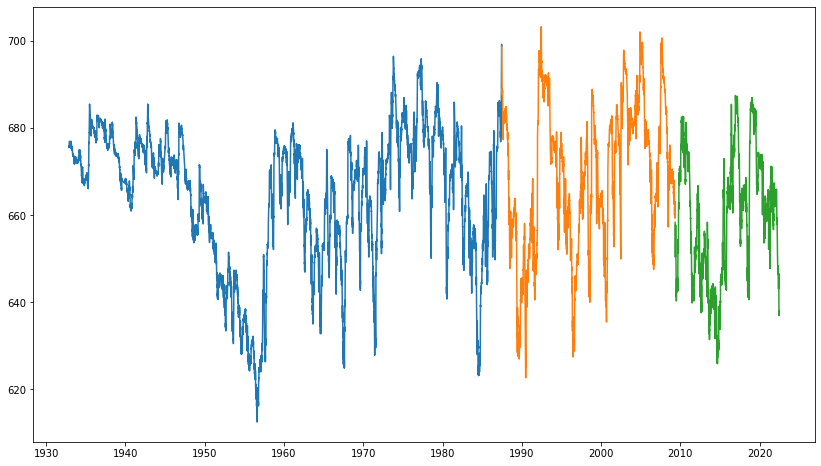

In [8]:
#Plotting out the splits to visualize them
plt.plot(train)
plt.plot(validate)
plt.plot(test)
plt.show()

In [9]:
def evaluate(target_var):
    '''
    This function takes in the actual values of the target_var from validate, and the predicted values stored in yhat_df, 
    and computes the rmse, rounding to 0 decimal places. Finally it returns the rmse. 
    '''
    rmse = round((mean_squared_error(validate[target_var], yhat_df[target_var]))**(1/2), 0)
    return rmse

In [10]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [11]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [12]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Modeling, Forecasting, Predicting

For modeling I will start with some basic predictions in order to acquire a baseline.
1. Last Observed Value: This will predict that future values will look like the most recent value.
2. Simple Average: This will predict that future values will look like a historical average. 
3. Moving Average: This will predict that future values will look like a recent period of time's average. 

Then I will move into more predictive models: 

4. Holt's Linear Trend
5. Previous Cycle

And finally if given time I want to try either:

6. Facebook Prophet
7. LinkedIn Greykite

### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

In [13]:
# Grabbing the most recent observation in train and assigning it to a variable
last_observed_level = train['water_level_elevation'][-1:][0]
last_observed_level

698.85

In [14]:
yhat_df = pd.DataFrame({'water_level_elevation': [last_observed_level]}, index=validate.index)
yhat_df.head()

,water_level_elevation
date,
1987-06-20,698.85
1987-06-21,698.85
1987-06-22,698.85
1987-06-23,698.85
1987-06-24,698.85


water_level_elevation -- RMSE: 34


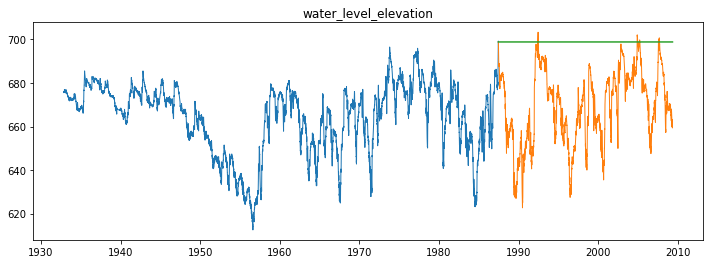

In [15]:
plot_and_eval('water_level_elevation')

In [16]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = 'water_level_elevation')
eval_df

,model_type,target_var,rmse
0,last_observed_value,water_level_elevation,34.0


### Simple Average

This takes the historical average and uses that to predict future values.   

This is a possible good option for an initial baseline.

In [17]:
# Computing the historical mean
avg_elevation = round(train['water_level_elevation'].mean(), 2)
avg_elevation

664.22

In [18]:
yhat_df = pd.DataFrame({'water_level_elevation': [avg_elevation]}, index=validate.index)
yhat_df.head()

,water_level_elevation
date,
1987-06-20,664.22
1987-06-21,664.22
1987-06-22,664.22
1987-06-23,664.22
1987-06-24,664.22


water_level_elevation -- RMSE: 18


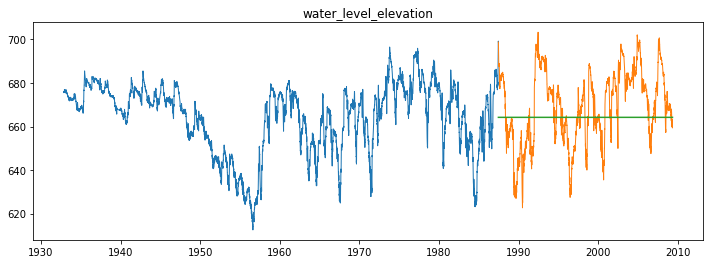

In [19]:
plot_and_eval('water_level_elevation')

In [20]:
eval_df = append_eval_df(model_type = 'avg_elevation', target_var = 'water_level_elevation')
eval_df

,model_type,target_var,rmse
0,last_observed_value,water_level_elevation,34.0
1,avg_elevation,water_level_elevation,18.0
